In [1]:
import sys
import os
sys.path.append(os.getcwd()+'/fivepoint')
import build.fivep as f
import time
import torch
import torch.nn.functional as F
from spherical_distortion.functional import create_tangent_images, unresample
from spherical_distortion.util import *
import matplotlib.pyplot as plt
from skimage import io
import os
import cv2

import sys
import pandas as pd
import numpy as np
import _spherical_distortion_ext._mesh as _mesh
import argparse

from random import sample
import imageio
from scipy.spatial.transform import Rotation as Rot

from utils.coord    import coord_3d
from utils.ransac   import *
from utils.keypoint import *
from utils.metrics  import *
from utils.camera_recovering import *

from os import listdir
from os.path import isfile, join, isdir
from tqdm import tqdm

sys.path.append(os.getcwd()+'/SPHORB-master')

import build1.sphorb_cpp as sphorb

/home/imonalc/anaconda3/envs/keypoints/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def sort_key(pts1, pts2, desc1, desc2, points):

    ind1 = np.argsort(pts1[:,2].numpy(),axis = 0)[::-1]
    ind2 = np.argsort(pts2[:,2].numpy(),axis = 0)[::-1]

    max1 = np.min([points,ind1.shape[0]])
    max2 = np.min([points,ind2.shape[0]])

    ind1 = ind1[:max1]
    ind2 = ind2[:max2]

    pts1 = pts1[ind1.copy(),:]
    pts2 = pts2[ind2.copy(),:]

    desc1 = desc1[:,ind1.copy()]
    desc2 = desc2[:,ind2.copy()]

    pts1 = np.concatenate((pts1[:,:2], np.ones((pts1.shape[0],1))), axis = 1 )
    pts2 = np.concatenate((pts2[:,:2], np.ones((pts2.shape[0],1))), axis = 1 )

    desc1 = np.transpose(desc1,[1,0]).numpy()
    desc2 = np.transpose(desc2,[1,0]).numpy()

    return pts1, pts2, desc1, desc2


def mnn_mather(desc1, desc2, method="mean_std"):
    sim = desc1 @ desc2.transpose()
    if method == "mean_std":
        k = 4
        threshold = sim.mean() + k * sim.std()
    sim_raw = sim.copy()
    sim[sim < threshold] = 0
    nn12 = np.argmax(sim, axis=1)
    nn21 = np.argmax(sim, axis=0)
    ids1 = np.arange(0, sim.shape[0])
    mask = (ids1 == nn21[nn12])
    matches = np.stack([ids1[mask], nn12[mask]])
    return matches.transpose(), sim_raw


def matched_points(pts1, pts2, desc1, desc2, opt, args_opt, match='ratio', use_new_method=0):
    if opt[-1] == 'p':
        porce = int(opt[:-1])
        n_key = int(porce/100 * pts1.shape[0])
    else:
        n_key = int(opt)

    s_pts1  = pts1.copy()[:n_key,:]
    s_pts2  = pts2.copy()[:n_key,:]
    s_desc1 = desc1.copy().astype('float32')[:n_key,:]
    s_desc2 = desc2.copy().astype('float32')[:n_key,:]

    if 'orb' in args_opt:
        s_desc1 = s_desc1.astype(np.uint8)
        s_desc2 = s_desc2.astype(np.uint8)
        hamming_distances = np.array([[cv2.norm(d1, d2, cv2.NORM_HAMMING) for d2 in s_desc2] for d1 in s_desc1])
        sim = -hamming_distances
        nn12 = np.argmin(hamming_distances, axis=1)
        nn21 = np.argmin(hamming_distances, axis=0)
        ids1 = np.arange(len(s_desc1))
        mask = (ids1 == nn21[nn12])
        matches = [cv2.DMatch(i, j, 0) for i, j in zip(ids1[mask], nn12[mask])]
    else:
        matches_idx, sim = mnn_mather(s_desc1, s_desc2)
        matches = [cv2.DMatch(i, j, 0) for i, j in matches_idx]

    M = np.zeros((2,len(matches)))
    for ind, match in zip(np.arange(len(matches)),matches):
        M[0,ind] = match.queryIdx
        M[1,ind] = match.trainIdx


    return s_pts1, s_pts2, s_pts1[M[0,:].astype(int),:3], s_pts2[M[1,:].astype(int),:3], sim


def get_error(x1, x2, Rx, Tx):

    S = computeEssentialMatrixByRANSAC(x1, x2)
    I = S[1]
    I = I.astype(np.int64)

    x1 = x1[I,:]
    x2 = x2[I,:]

    F = calc_ematrix(x1,x2)


    R1,R2,T1,T2 = decomposeE(F)

    R,T = choose_rt(R1,R2,T1,T2,x1,x2)

    R_error = r_error(Rx,R)
    T_error = t_error(Tx,T)

    return R_error, T_error


def get_descriptor(descriptor):
    if descriptor == 'sphorb':
        return 'sphorb', 'erp', 640, 0
    elif descriptor == 'sift':
        return 'sift', 'erp', 512, 0
    elif descriptor == 'tsift':
        return 'sift', 'tangent', 512, 0
    elif descriptor == 'orb':
        return 'orb', 'erp', 512, 0
    elif descriptor == 'torb':
        return 'orb', 'tangent', 512, 0
    elif descriptor == 'spoint':
        return 'superpoint', 'erp', 512, 0
    elif descriptor == 'tspoint':
        return 'superpoint', 'tangent', 512, 0
    elif descriptor == 'alike':
        return 'alike', 'erp', 512, 0
    elif descriptor == 'talike':
        return 'alike', 'tangent', 512, 0
    elif descriptor == 'Proposed':
        return 'superpoint', 'tangent', 512, 1
    elif descriptor == 'Ltspoint':
        return 'superpoint', 'tangent', 512, 2
    elif descriptor == 'Ftspoint':
        return 'superpoint', 'tangent', 512, 3


def get_error(x1, x2, Rx, Tx):

    S = computeEssentialMatrixByRANSAC(x1, x2)
    I = S[1]
    I = I.astype(np.int64)

    x1 = x1[I,:]
    x2 = x2[I,:]

    F = calc_ematrix(x1,x2)


    R1,R2,T1,T2 = decomposeE(F)

    R,T = choose_rt(R1,R2,T1,T2,x1,x2)

    R_error = r_error(Rx,R)
    T_error = t_error(Tx,T)

    return R_error, T_error


def AUC(ROT, TRA, MET, L):

    RAUC  = np.zeros(len(L))
    TAUC  = np.zeros(len(L))

    for index, t in enumerate(L):
        ids = np.where(ROT<np.radians(t))[0]
        RAUC[index] = len(ids)/len(ROT)

    for index, t in enumerate(L):
        ids = np.where(TRA<np.radians(t))[0]
        TAUC[index] = len(ids)/len(TRA)

    return RAUC, TAUC, np.array(MET)


def get_data(DATAS):
    if len(DATAS) == 1:
        data = DATAS[0]
    elif set(['Urban1','Urban2','Urban3','Urban4']) == set(DATAS):
        data = 'Outdoor'
    elif set(['Realistic','Interior1','Interior2','Room','Classroom']) == set(DATAS):
        data = 'Indoor'
    elif set(['Urban1_R','Urban2_R','Urban3_R','Urban4_R','Realistic_R','Interior1_R','Interior2_R','Room_R','Classroom_R']) == set(DATAS):
        data = 'OnlyRot'
    elif set(['Urban1_T','Urban2_T','Urban3_T','Urban4_T','Realistic_T','Interior1_T','Interior2_T','Room_T','Classroom_T']) == set(DATAS):
        data = 'OnlyTra'
    else:
        data = ''
        for DA in DATAS:
            data+=DA

    return data


def get_kd(array):

    array = np.array(array)
    delimiter = int(array[-1])
    A = array[:-1]
    K = A[:delimiter].reshape(-1,3)
    D = A[delimiter:].reshape(-1,32)
    return K,D


def normalize_features(features):
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    normalized_features = features / norms

    threshold = 0.2
    normalized_features = np.minimum(normalized_features, threshold)

    norms = np.linalg.norm(normalized_features, axis=1, keepdims=True)
    normalized_features /= norms

    return normalized_features


In [3]:
points = 500
match = "ratio"
solver = "None"
inliers = "5PA"
descriptor = "tsift"
path = "./data/Farm_pair"  #"./data/data_100/Room/0"

In [10]:
def test(points = 500,
match = "ratio",
descriptor = "tsift",
path = "./data/Farm_pair",):
    t0 = time.time()
    descriptor = descriptor

    opt, mode, sphered, use_our_method = get_descriptor(descriptor)
    base_order = 0  # Base sphere resolution
    sample_order = 8  # Determines sample resolution (10 = 2048 x 4096)
    scale_factor = 1.0  # How much to scale input equirectangular image by
    save_ply = False  # Whether to save the PLY visualizations too
    dim = np.array([2*sphered, sphered])

    path_o = path + '/O.png'
    path_r = path + '/R.png'
    img_o = load_torch_img(path_o)[:3, ...].float()
    img_o = F.interpolate(img_o.unsqueeze(0), scale_factor=scale_factor, mode='bilinear', align_corners=False, recompute_scale_factor=True).squeeze(0)
    img_r = load_torch_img(path_r)[:3, ...].float()
    img_r = F.interpolate(img_r.unsqueeze(0), scale_factor=scale_factor, mode='bilinear', align_corners=False, recompute_scale_factor=True).squeeze(0)
    img_o = torch2numpy(img_o.byte())
    img_r = torch2numpy(img_r.byte())
    img_o = cv2.cvtColor(img_o, cv2.COLOR_BGR2RGB)
    img_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB)
    height_threshold = 0.7 * img_o.shape[0]


    print(path_o)
    t1 = time.time()
    print("image:", t1-t0)
    if opt != 'sphorb':
        corners = tangent_image_corners(base_order, sample_order)
        pts1, desc1 = process_image_to_keypoints(path_o, corners, scale_factor, base_order, sample_order, opt, mode)
        print(descriptor, len(pts1))
        pts2, desc2 = process_image_to_keypoints(path_r, corners, scale_factor, base_order, sample_order, opt, mode)
        pts1[pts1[:,0] > img_o.shape[1], 0] -= img_o.shape[1]
        pts2[pts2[:,0] > img_o.shape[1], 0] -= img_o.shape[1]
    else:      
        os.chdir('SPHORB-master/')
        pts1, desc1 = get_kd(sphorb.sphorb(path_o, points))
        pts2, desc2 = get_kd(sphorb.sphorb(path_r, points))
        os.chdir('../')
    if opt == "sift":
        desc1 = normalize_features(desc1)
        desc2 = normalize_features(desc2)

    #print(desc1.shape, desc1)
    pts1, pts2, desc1, desc2 = sort_key(pts1, pts2, desc1, desc2, points)
    t2 = time.time()
    print("detection:", t2-t1)
    if len(pts1.shape) == 1:
        pts1 = pts1.reshape(1,-1)

    print(desc1.shape)
    s_pts1, s_pts2, x1, x2, sim = matched_points(pts1, pts2, desc1, desc2, "100p", opt, match, use_new_method=use_our_method)
    return sim


In [11]:
sim_p = test(descriptor="Proposed")
sim_o = test(descriptor="orb")
sim_to = test(descriptor="torb")
sim_s = test(descriptor="sift")
sim_ts = test(descriptor="tsift")
sim_sp = test(descriptor="spoint")

./data/Farm_pair/O.png
image: 0.30107712745666504


/home/imonalc/anaconda3/envs/keypoints/lib/python3.7/site-packages/torch/nn/functional.py:4228: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Proposed 606
detection: 1.2761116027832031
(500, 256)
./data/Farm_pair/O.png
image: 0.3442838191986084
orb 10000
detection: 0.7844505310058594
(500, 32)
./data/Farm_pair/O.png
image: 0.3025662899017334
torb 13825
detection: 0.7575478553771973
(500, 32)
./data/Farm_pair/O.png
image: 0.304149866104126
sift 10001
detection: 1.8932225704193115
(500, 128)
./data/Farm_pair/O.png
image: 0.33896636962890625
tsift 1532
detection: 2.9502756595611572
(500, 128)
./data/Farm_pair/O.png
image: 0.3323554992675781
spoint 21776
detection: 1.4474866390228271
(500, 256)


In [12]:
sim_list = [sim_sp, sim_p, sim_o, sim_to, sim_s, sim_ts]
nm_list = ["SPoint", "Tspoint" "ORB", "TORB", "SIFT", "TSIFT"]

In [7]:
sim_dict = {
    "spoint": sim_sp,
    "tspoint": sim_p,
    "orb": sim_o,
    "torb": sim_to,
    "sift": sim_s,
    "tsift": sim_ts 
}

In [8]:
import pickle
with open("sim.pickle", mode='wb') as f:
    pickle.dump(sim_dict,f)

In [9]:
import scipy

1.7599208688451444 659
4.389849921411011 1539
-0.12101929927358679 9
-0.026129766138411892 21
0.18415407756659707 144
-0.1579478163595165 46


IndexError: list index out of range

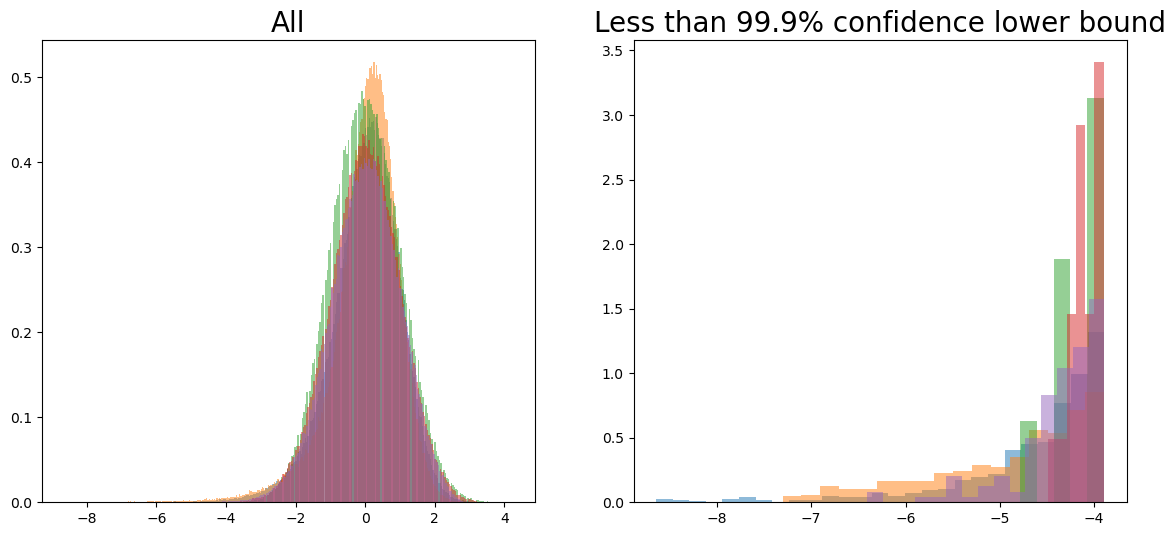

In [13]:
def plot(sim_list):
    fig_img, axs = plt.subplots(1, 2, figsize=(6*2+2, 6))
    axs[0].set_title("All", fontsize=20)
    axs[1].set_title("Less than 99.9% confidence lower bound", fontsize=20)
    for idx, sim in enumerate(sim_list):
        flat_sim = sim.flatten().copy()
        flat_sim = 1-flat_sim
        flat_sim = (flat_sim - np.mean(flat_sim)) / np.std(flat_sim)
        threshold = 3.89
        filtered_sim = flat_sim[flat_sim < -threshold].copy()
        print(scipy.stats.kurtosis(flat_sim), len(filtered_sim))
        #axs[0].hist(flat_sim, bins=50,alpha=0.5, label=nm_list[idx])
        #axs[1].hist(filtered_sim, bins=50, alpha=0.5, label=nm_list[idx])
        axs[0].hist(flat_sim, bins="auto", alpha=0.5, label=nm_list[idx], density=True)
        axs[1].hist(filtered_sim, bins="auto", alpha=0.5, label=nm_list[idx], density=True)

    for i in range(2):
        ax = axs[i]
        ax.tick_params(axis='both', labelsize=20)
        ax.set_ylabel('Frequency', fontsize=20)
        ax.set_xlabel('Normalized distance', fontsize=20)
        ax.legend(loc='upper left', fontsize=20)
    plt.show()
plot(sim_list)

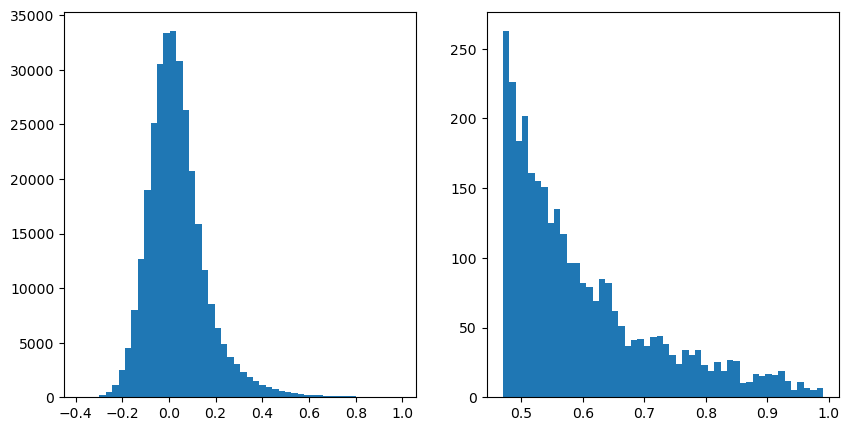

In [7]:
flattened_array = sim.flatten()
filtered_array2 = flattened_array.copy()#[flattened_array > 0]
threshold = np.percentile(flattened_array, 99)
filtered_array = flattened_array[flattened_array >= threshold].copy()
fig_img, axs_img = plt.subplots(1, 2, figsize=(4*2+2, 5))
axs_img[0].hist(filtered_array2, bins=50)
axs_img[1].hist(filtered_array, bins=50)
plt.show()